- Класс ниже детектит разладку во временном ряду используя CUSUM
- Находим все предолагаемые точки разладки
- Рассматриваем ряд после последней точки как область для refit'a

In [9]:
############# Параметры ################
path_to_timeseries = 'data/Project 1_2024.xlsx'
path_to_pickled_detector = 'model/changepoint_detector.pkl'
timeseries_column_name = 'Balance'
date_index_column_name = 'Date'

In [26]:
import pandas as pd
import scipy.stats as stats
import pickle 
import numpy as np
from typing import Tuple
import os
from datetime import datetime
from matplotlib import pyplot as plt

In [56]:
# read the whole timeseries
root_dir = os.path.dirname(os.getcwd())
timeseries = pd.read_excel(os.path.join(root_dir, path_to_timeseries), index_col=date_index_column_name, parse_dates=[date_index_column_name])[timeseries_column_name]
timeseries.head(100)

Date
2017-01-09   -0.155904
2017-01-10   -0.125572
2017-01-11    0.007767
2017-01-12    0.800391
2017-01-13   -0.019721
                ...   
2017-04-14   -0.015038
2017-04-15    0.000000
2017-04-16    0.000000
2017-04-17   -0.148480
2017-04-18   -0.070663
Name: Balance, Length: 100, dtype: float64

In [57]:
class CusumMeanDetector():
    """
    Probabilistic CUSUM for change point detection.
    For each new datapoint we directly obtain a measure of how extreme the respective observation is.
    Once a certain threshold of ‘unlikeliness’ is surpassed, we mark the respective timestamp as a change point and restart the algorithm.
    """
        
    def __init__(self, t_warmup = 30, p_limit = 0.01) -> None:
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        
        self._reset()
        
        

    def predict_next(self, y: float) -> Tuple[float,bool]:
        self._update_data(y)

        if self.current_t == self._t_warmup:
            self._init_params()
        
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            if is_changepoint:
                self._reset()

            return (1-prob), is_changepoint
        
        else:
            return 0, False
            
    
    def _reset(self) -> None:
        self.current_t = 0
                
        self.current_obs = []
        
        self.current_mean = None
        self.current_std = None
            
    
    def _update_data(self, y: float) -> None:
        self.current_t += 1
        self.current_obs.append(y)

        
    
    def _init_params(self) -> None:
        self.current_mean = np.mean(self.current_obs)
        self.current_std = np.std(self.current_obs)
             
    
    def _check_for_changepoint(self) -> Tuple[float,bool]:
        standardized_sum = np.sum(self.current_obs - self.current_mean)/(self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum))
        
        return prob, prob < self._p_limit
    
    
    def _get_prob(self, y: float) -> bool:
        p = stats.norm.cdf(abs(y))
        prob = 2*(1 - p)
        
        return prob

In [58]:
class DateTrackingCusum(CusumMeanDetector):
    """
    The same as above but ensures that a timeseries ordered by datetime index is passed correctly.
    Saves the last passed value index.
    """
    def __init__(self, t_warmup = 30, p_limit = 0.01, last_datetime=None) -> None:
        super().__init__(t_warmup = t_warmup, p_limit = p_limit)
        self.last_datetime=last_datetime

    def predict_next(self, y: float, y_datetime: datetime) -> Tuple[float,bool]:
        if self.last_datetime and self.last_datetime >= y_datetime:
            raise ValueError(f"Trying to pass a past value ({self.last_datetime} >= {y_datetime})")

        self.last_datetime = y_datetime
        prob, decision = super().predict_next(y=y)
        return self.last_datetime, prob, decision

In [59]:
detector = DateTrackingCusum(t_warmup = 30, p_limit = 0.1, last_datetime=None)

changepoints = [detector.predict_next(y=value, y_datetime=pd.Timestamp(index).to_pydatetime()) for index, value in timeseries.items()]

In [61]:
detected = [pd.to_datetime(changepoint[0], ) for changepoint in changepoints if changepoint[2] is True]

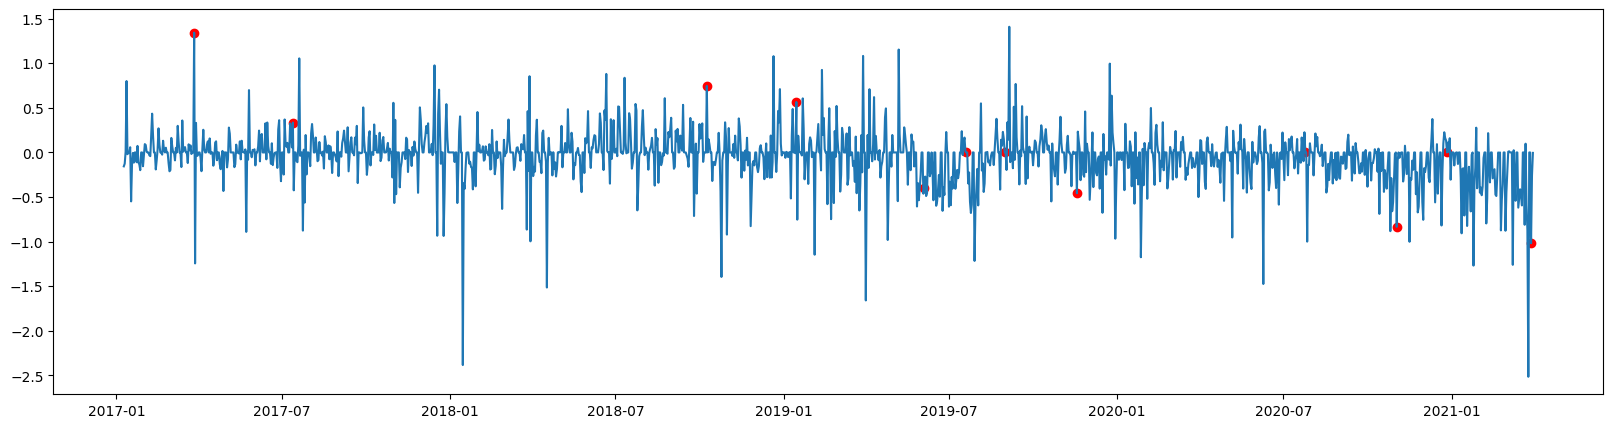

In [71]:
plt.figure(figsize=(20, 5))
plt.scatter(detected, timeseries[detected], c = "r")
plt.plot(timeseries)

In [8]:
with open(os.path.join(root_dir, path_to_pickled_detector), "wb") as f:
    pickle.dump(detector, f)